Analysis of recent coronavirus data for different countries and regions.  
Author: Javier Moldon  
More info in https://github.com/jmoldon/coronavirus_analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import datetime
import matplotlib.dates as mdates


In [2]:
matplotlib.rcParams["figure.figsize"] = 20,9
import warnings
warnings.filterwarnings('ignore')

# General statistics

Data comes from Johns Hopkins University at https://github.com/CSSEGISandData/COVID-19 that is updated daily.

In [3]:
# import data from github url, url1 -Confirmed, url2 -Deaths. url3 -Recovered
data_path = './data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
file1 = data_path + 'time_series_19-covid-Confirmed.csv'
file2 = data_path + 'time_series_19-covid-Deaths.csv'
file3 = data_path + 'time_series_19-covid-Recovered.csv'

df1 = pd.read_csv(file1, error_bad_lines=False)
df2 = pd.read_csv(file2, error_bad_lines=False)
df3 = pd.read_csv(file3, error_bad_lines=False)

#display(df1.head(), df2.head(), df3.head())

In [4]:
# Convert date columns to a time series
df1u = pd.melt(df1, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Confirmed')
df2u = pd.melt(df2, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Deaths')
df3u = pd.melt(df3, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Recovered')

df1u['DateTime'] = pd.to_datetime(df1u['DateTime'])
df2u['DateTime'] = pd.to_datetime(df2u['DateTime'])
df3u['DateTime'] = pd.to_datetime(df3u['DateTime'])

data = pd.concat([df1u, df2u, df3u], axis=1, join='inner')
data = data.loc[:,~data.columns.duplicated()] # Remove columns that were repeated in the three datasets
data['Active'] = data['Confirmed']-data['Deaths']-data['Recovered']
data['mortality_fraction'] = data['Deaths']/data['Confirmed']
data['Province/State'][data['Province/State'].isna()] = ''

In [5]:
#Example table:
#data[['Country/Region','Confirmed','Deaths','Recovered']]

In [6]:
#I need to remove a few points manually that I identified as bad ones
data.drop(data[(data['Country/Region']=='Spain') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Italy') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Netherlands') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-13', '%Y-%m-%d'))].index, inplace=True)

In [7]:
#data['Country/Region'].unique()

## List of most affected countries (sorted by number of confirmed cases)

In [8]:
data.groupby(['Country/Region'])[['Confirmed', 'Deaths', 'Recovered']].max().sort_values(by='Confirmed')[::-1][0:15]

,Confirmed,Deaths,Recovered
Country/Region,,,
China,67786,3062,51553
Italy,17660,1266,1439
Iran,11364,514,2959
"Korea, South",7979,66,510
Spain,5232,133,193
Germany,3675,7,46
France,3661,79,12
Switzerland,1139,11,4
Norway,996,0,1


## List of most affected countries/provinces (sorted by number of deaths)

In [9]:
data.groupby(['Country/Region', 'Province/State'])[['Confirmed', 'Deaths', 'Recovered']].max().sort_values(by='Deaths')[::-1][0:15]

,,Confirmed,Deaths,Recovered
Country/Region,Province/State,,,
China,Hubei,67786,3062,51553
Italy,,17660,1266,1439
Iran,,11364,514,2959
Spain,,5232,133,193
France,France,3661,79,12
"Korea, South",,7979,66,510
US,Washington,568,37,1
China,Henan,1273,22,1249
Japan,,701,19,118


# Evolution of cases (Confirmed, Deaths, Active and Recovery) per country

All plots have the same information. Left: log scale, right: linear scale. Bottom-right: is a zoom to show the correct scale for deaths. The straight line is a fit to a logistic growth when possible. If the fit does not converge (low number of points in early stages) a simple exponential is used. The dashed line is a prediction based on the fit. 

In [10]:
def select_country(data, country='', province='', start_date='2020-02-15', end_date='2021-03-11', show_numbers=False):
    # Select by country
    if country != '':
        cond1 = data['Country/Region'] == country
    else:
        cond1 = data['Country/Region'].notna()  # Select any country
    # Select by province
    if province != '':
        cond2 = data['Province/State'] == province
    else:
        cond2 = data['Province/State'] != np.nan  # Select any province
    # Select by time range
    if start_date != '':
        t0 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    else:
        t0 = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')
    if end_date != '':
        t1 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    else:
        t1 = datetime.datetime.strptime('9999-01-01', '%Y-%m-%d')
    cond3 = (data['DateTime'] >= t0) & (data['DateTime'] < t1)
    selection = cond1&cond2&cond3
    if show_numbers:
        print('Number of entries per country: {}'.format(cond1.sum()))
        print('Number of entries per province: {}'.format(cond2.sum()))
        print('Number of entries per time range: {}'.format(cond3.sum()))
        print('Number of entries selected: {}'.format(selection.sum()))
    return data[selection]

In [57]:
def my_exponential(x,  b, alpha, x0):
    return  b * np.exp(alpha * (x-x0))

def my_logistic(x, L, k, x0):
    return L/(1+np.exp(-k*(x-x0)))

def fit_data(data, future_d=5):
    # Will try to fit a logistic growth. If not possible fit an exponential
    dates = pd.date_range(start=data['DateTime'].iloc[0], end=data['DateTime'].iloc[-1]+datetime.timedelta(days=future_d))
    prediction = pd.DataFrame({'DateTime':dates})
    xx = mdates.date2num(dates)
    for column in ['Confirmed', 'Deaths', 'Recovered']:
        x = mdates.date2num(data['DateTime'])
        y = data[column].values
        try:
            popt, pcov = curve_fit(my_logistic, x, y, p0=(np.max(y), 1, int(np.mean(x))))
            func = my_logistic
        except RuntimeError:
            popt, pcov = curve_fit(my_exponential, x, y, p0=(np.max(y), 1, np.mean(x)))
            func = my_exponential
        c_fit = func(x, *popt)
        data.loc[:, column+'_fit'] = c_fit
        upper_bound, lower_bound, y_err = calc_ci(popt, pcov, xx, func)
        prediction[column+'_pred'] = func(xx, *popt)
        prediction[column+'_pred_upper'] = upper_bound
        prediction[column+'_pred_lower'] = lower_bound
    return data, prediction

def calc_ci(popt, pcov, xx, func, N=1000):
    popt_err = np.sqrt(np.diagonal(pcov))
    params_sim = np.empty((len(popt), N))
    for i, (p, p_err) in enumerate(zip(popt, popt_err)):
        params_sim[i] = np.random.normal(p, p_err, N)
    y_err = np.empty_like(xx)
    upper_bound = np.empty_like(xx)
    lower_bound = np.empty_like(xx)
    for i, xi in enumerate(xx):
        y_err[i] = np.std(func(xi, *params_sim))
        upper_bound[i] = func(xi, *popt) + y_err[i]
        lower_bound[i] = func(xi, *popt) - y_err[i]
    return upper_bound, lower_bound, y_err


#def fit_data(data, fit='exp'):
#    # Choose between exponential or logistic fit
#    for column in ['Confirmed', 'Deaths', 'Recovered']:
#        try:
#            x = mdates.date2num(data['DateTime'])
#            y = data[column].values
#            if fit=='exp':
#                popt, pcov = curve_fit(my_exponential, x, y, p0=(1., 1))
#                func = my_exponential 
#            elif fit=='logistic':
#                popt, pcov = curve_fit(my_logistic, x, y, p0=(np.max(y), 1, x[-3]))
#                func = my_logistic
#            c_fit = func(x, *popt)
#            data.loc[:, column+'_fit'] = c_fit
#        except RuntimeError:
#            data.loc[:, column+'_fit'] = np.nan
#    return data

In [58]:
def plot_country(data, country='Spain', province='', start_date='2020-02-15', end_date='2021-03-12', show_numbers=False):
    data_country, prediction = fit_data(select_country(data, country=country, province=province, start_date=start_date, end_date=end_date, show_numbers=show_numbers))
    
    gridsize = (3, 2)
    fig = plt.figure(figsize=(18, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=3)
    ax2 = plt.subplot2grid(gridsize, (0, 1), rowspan=2)
    ax3 = plt.subplot2grid(gridsize, (2, 1))
    plt.subplots_adjust(hspace=0)

    colors = {'Confirmed': '#3498db',
              'Deaths': 'tomato',
              'Recovered': 'g',
               'Active': 'k'}
    active_fit = data_country['Confirmed_fit']-data_country['Recovered_fit']-data_country['Deaths_fit']
    for ax in [ax1,ax2,ax3]:
        ax.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color=colors['Confirmed'], label='Confirmed')
        ax.plot(data_country['DateTime'], data_country['Deaths'],    'o', color=colors['Deaths'], label='Deaths')
        ax.plot(data_country['DateTime'], data_country['Recovered'], 'o', color=colors['Recovered'], label='Recovered')
        ax.plot(data_country['DateTime'], data_country['Active'],    'o', color=colors['Active'], label='Active')
        ax.plot(data_country['DateTime'], active_fit,                '-', color=colors['Active'])
    
        ax.plot(data_country['DateTime'], data_country['Recovered_fit'], '-', color=colors['Recovered'])
        ax.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color=colors['Confirmed'])
        ax.plot(data_country['DateTime'], data_country['Deaths_fit'],    '-', color=colors['Deaths'])
        # Model and prediction
        active_pred = prediction['Confirmed_pred']-prediction['Recovered_pred']-prediction['Deaths_pred']
        for column in ['Confirmed', 'Deaths', 'Recovered']:
            ax.plot(prediction['DateTime'], prediction[column+'_pred'], '--', color=colors[column])
            ax.fill_between(prediction['DateTime'], prediction[column+'_pred_upper'], prediction[column+'_pred_lower'], color=colors[column], alpha=0.5)
    
        ax.plot(prediction['DateTime'], active_pred, '--', color=colors['Active'])

    ax3.set_ylim(0, np.max(data_country['Deaths'])*1.5)
    #ax2.set_ylim(0,1e5)
    ax1.set_ylim(0.5,1e5)

    ax1.set_ylabel('Number of cases (log scale)')
    ax2.set_ylabel('Number of cases (linear scale)')
    ax3.set_ylabel('Zoom')
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax1.grid()

    fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    fig.savefig(f'./plots/{country}{province}.png', bbox_inches='tight', dpi=150)
    return data_country

## Early onset: China regions

Most of the regions have almost completed the cycle and active cases are disappearing. Note that China Hubei (the original area) has a large number of confirmed cases (70000), but the other regions have very low number of cases, with number around 1200-500 or even less.

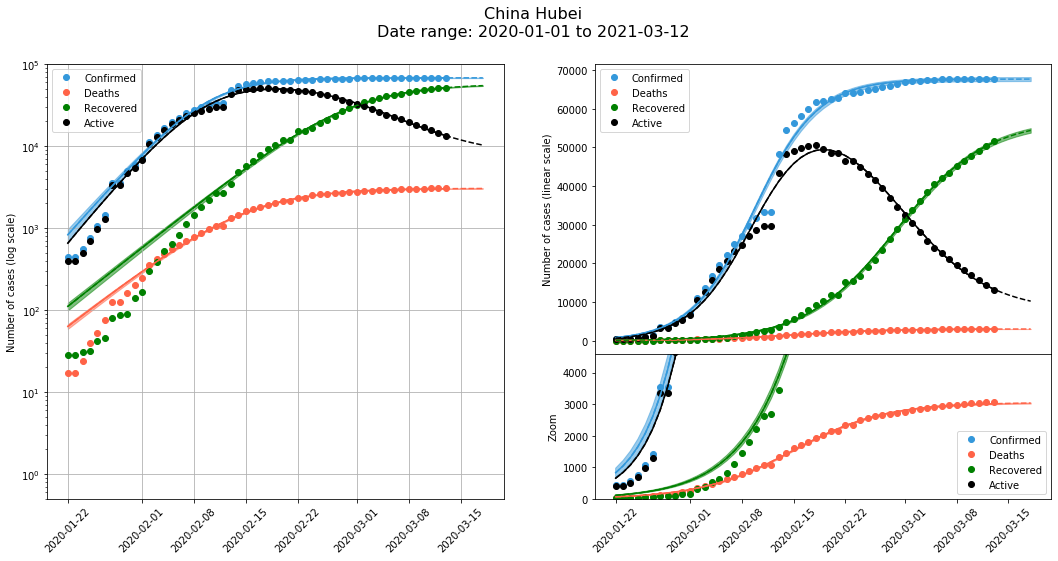

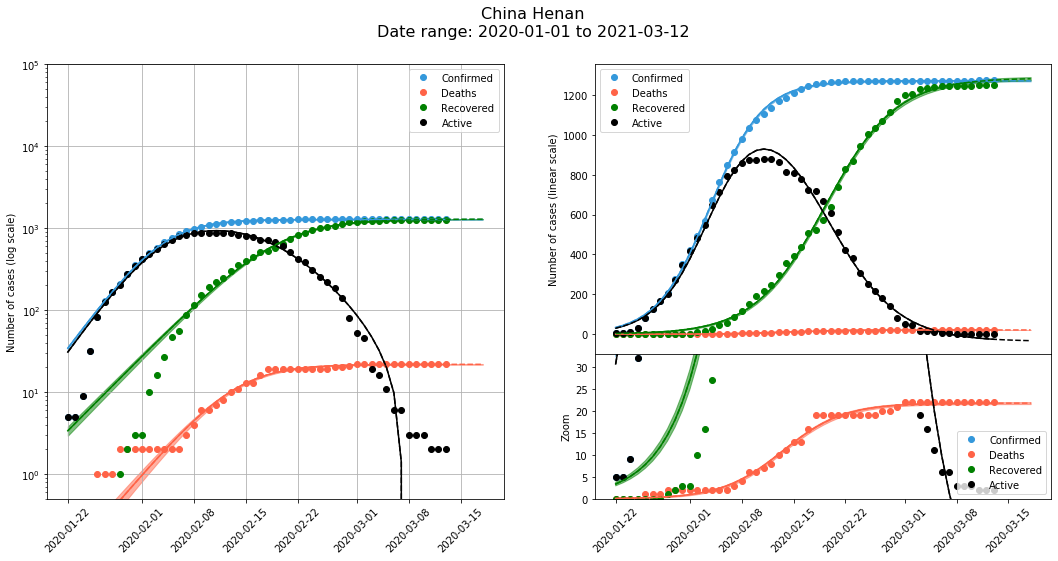

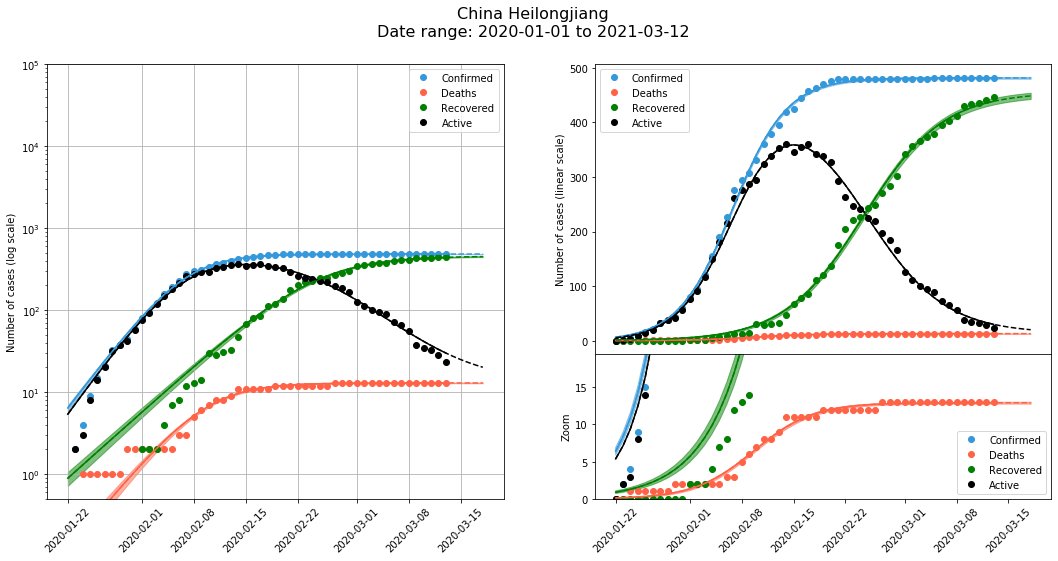

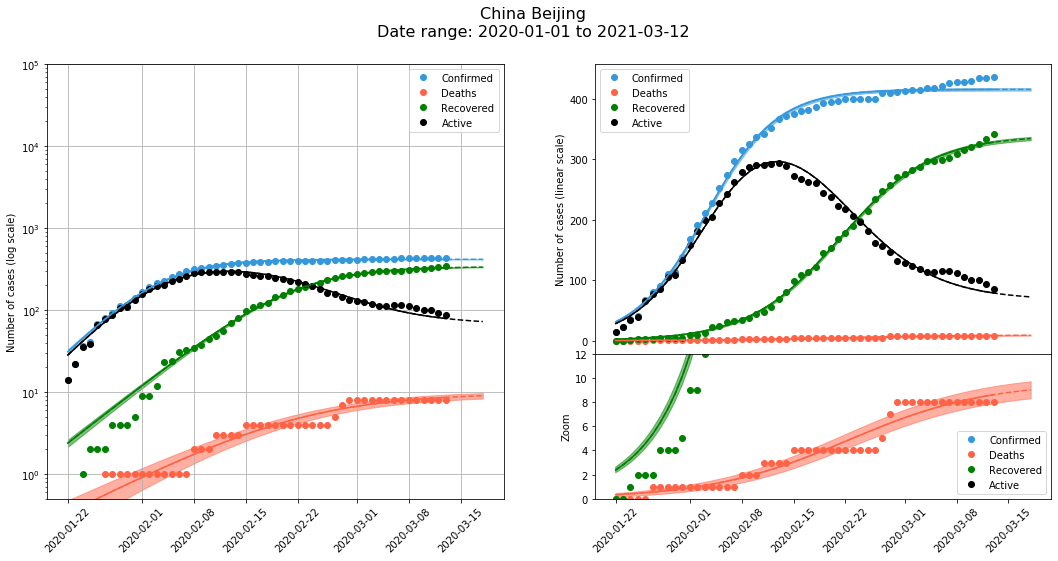

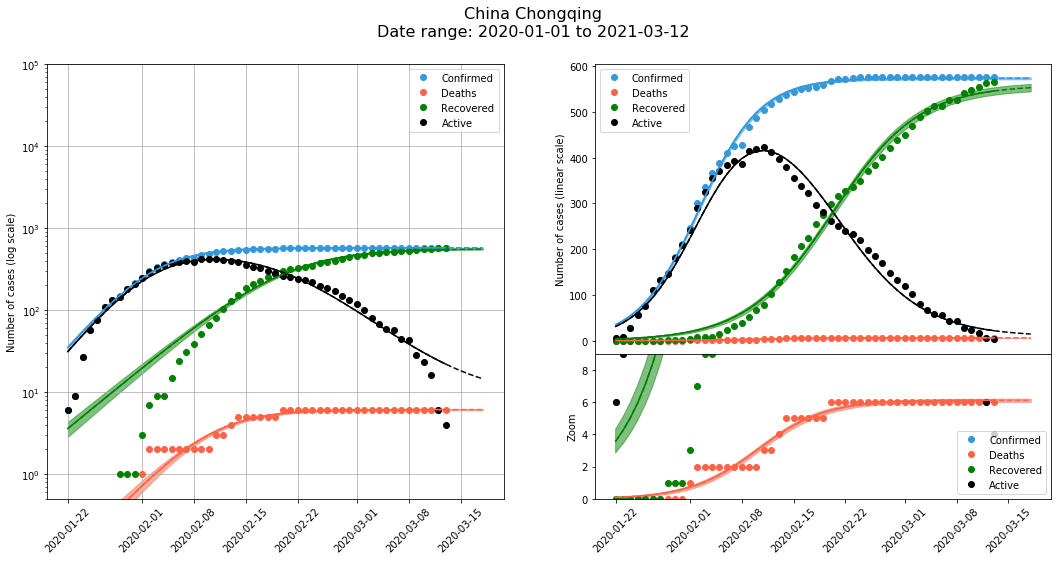

In [45]:
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:10].index
for i in idx:
    country, province = i
    if country == 'China':
        plot_country(data, country=country, province=province, start_date='2020-01-01', show_numbers=False)

## Europe

The number of confirmed cases and deaths is very high in countries like Italy, Spain and France. Note high rate of deaths, much higher than in , which is still in very exponential stage with no signs of flattening.

In general, more days will be needed for a more accurate fit and prediction, but we are still in a high-growth phase.

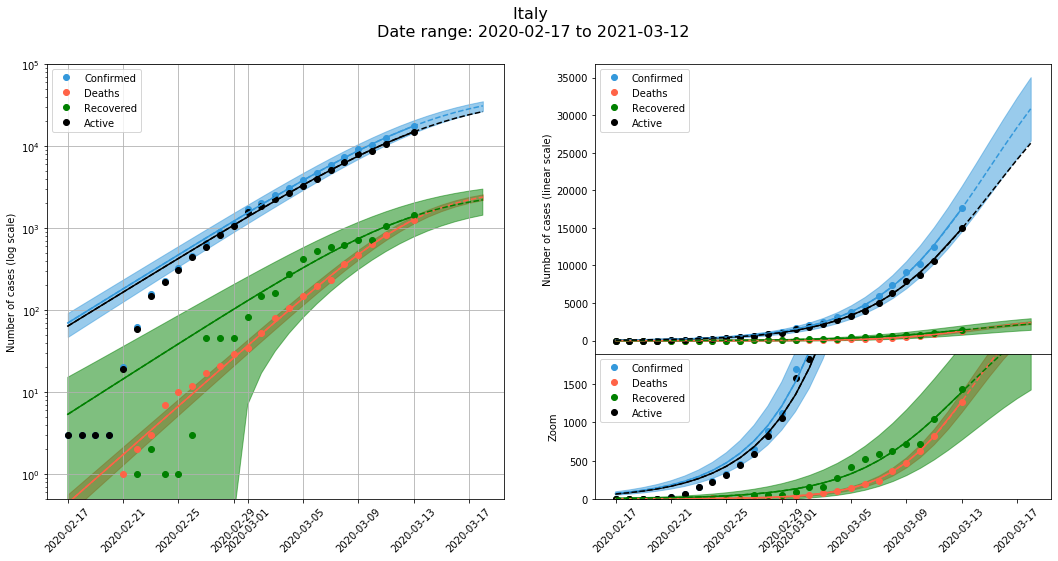

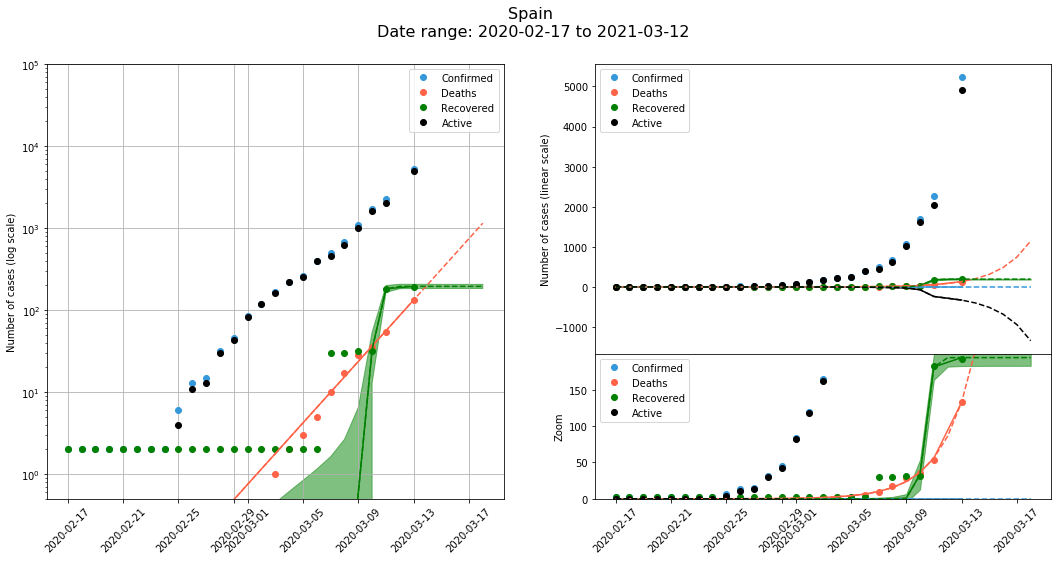

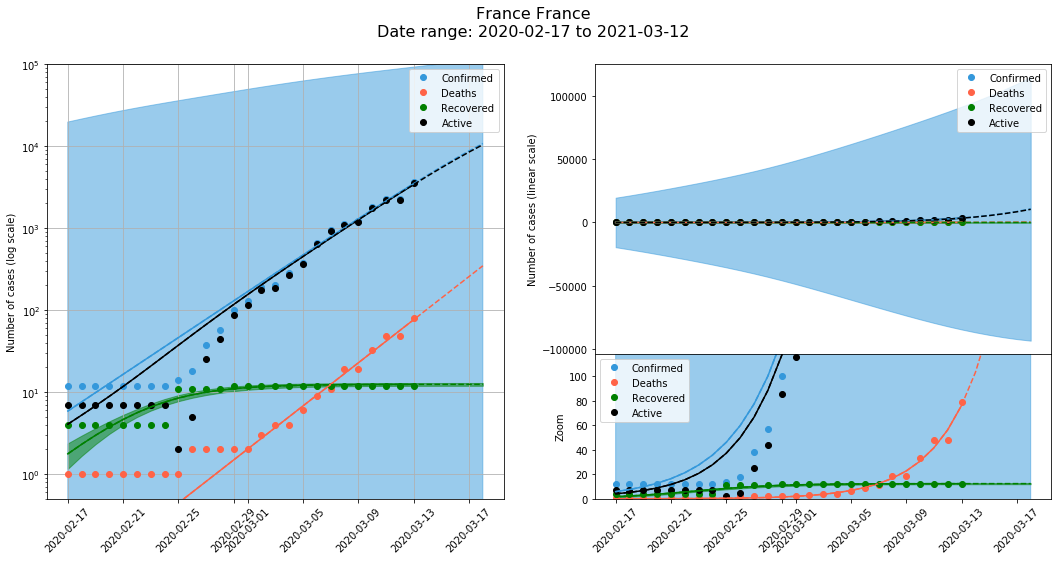

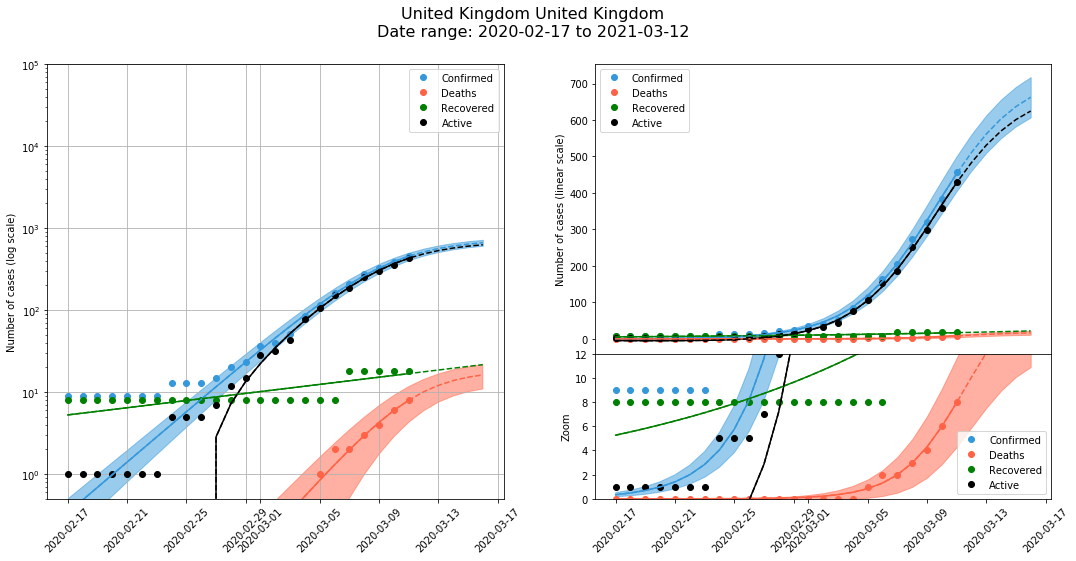

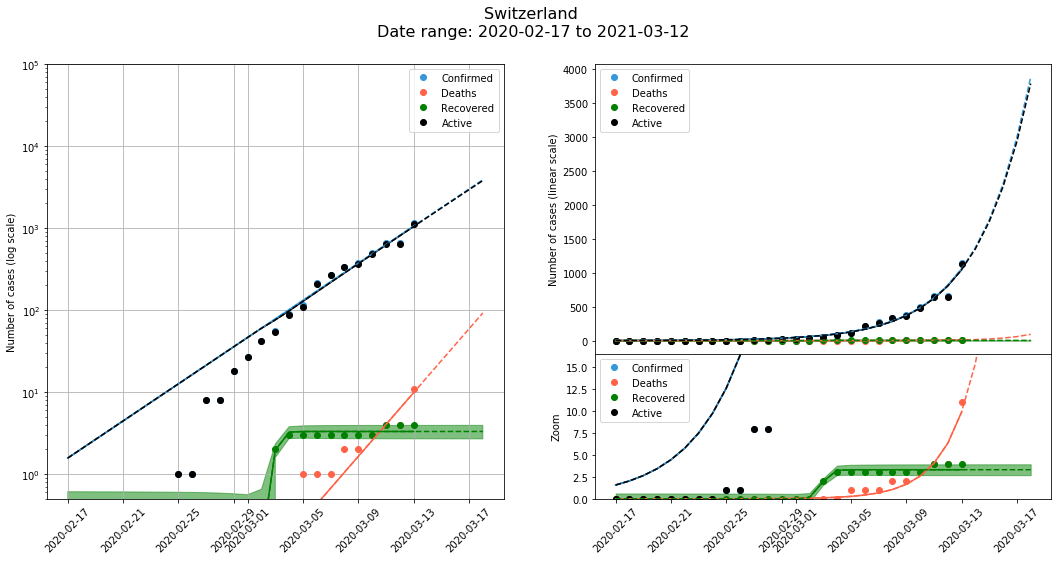

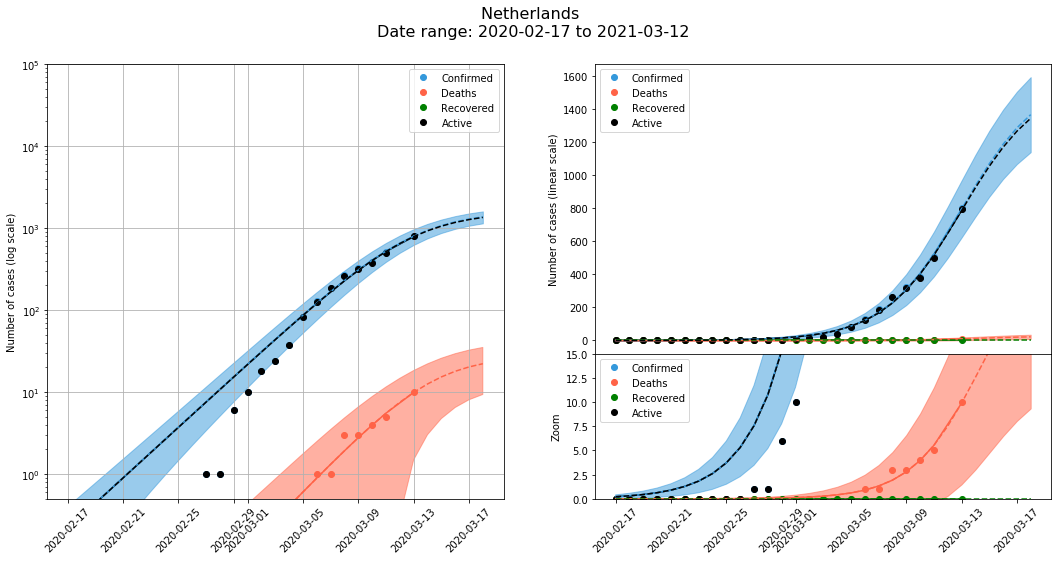

In [59]:
europe_list = [
    ['Italy', ''],
    ['Spain', ''],
    ['France', 'France'],
    ['United Kingdom', 'United Kingdom'],
    ['Switzerland', ''],
    ['Netherlands', '']
]
for country, province in europe_list:
    plot_country(data, country=country, province=province, start_date='2020-02-17', show_numbers=False)

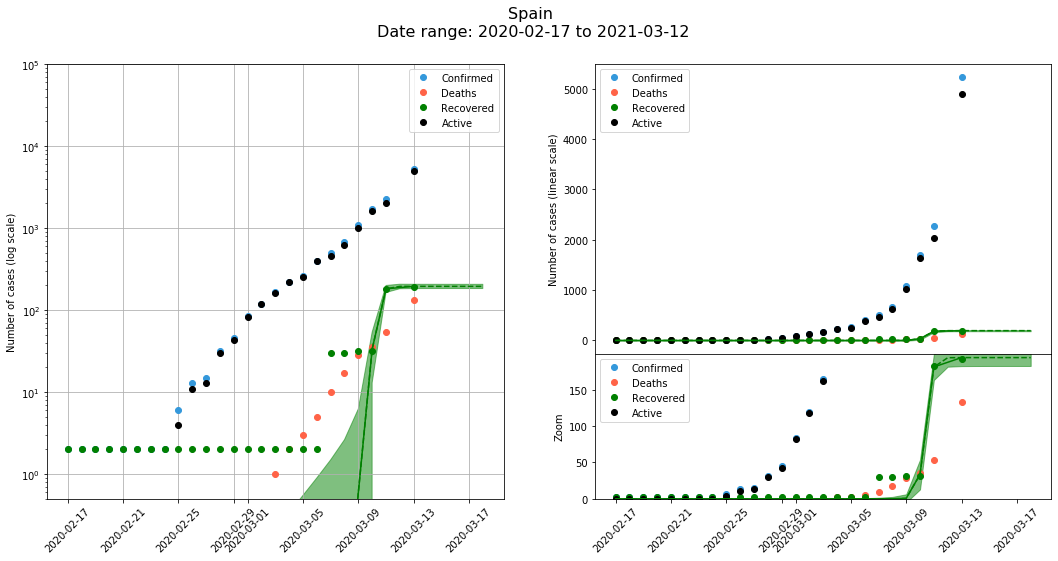

In [54]:
spain = plot_country(data, country='Spain', province=province, start_date='2020-02-17', show_numbers=False)
spain, prediction = fit_data(spain, future_d = 10)

     DateTime  Confirmed_pred  Deaths_pred  Recovered_pred
0  2020-02-17        0.298718     0.002764    2.120707e-39
1  2020-02-18        0.441479     0.004254    1.436635e-37
2  2020-02-19        0.652467     0.006547    9.732226e-36
3  2020-02-20        0.964288     0.010076    6.592922e-34
4  2020-02-21        1.425131     0.015507    4.466257e-32
5  2020-02-22        2.106217     0.023865    3.025586e-30
6  2020-02-23        3.112800     0.036728    2.049629e-28
7  2020-02-24        4.600441     0.056524    1.388485e-26
8  2020-02-25        6.799041     0.086991    9.406041e-25
9  2020-02-26       10.048377     0.133879    6.371954e-23
10 2020-02-27       14.850604     0.206040    4.316566e-21
11 2020-02-28       21.947868     0.317096    2.924181e-19
12 2020-02-29       32.436991     0.488012    1.980934e-17
13 2020-03-01       47.938979     0.751052    1.341948e-15
14 2020-03-02       70.849535     1.155872    9.090788e-14
15 2020-03-03      104.709292     1.778890    6.158392e-

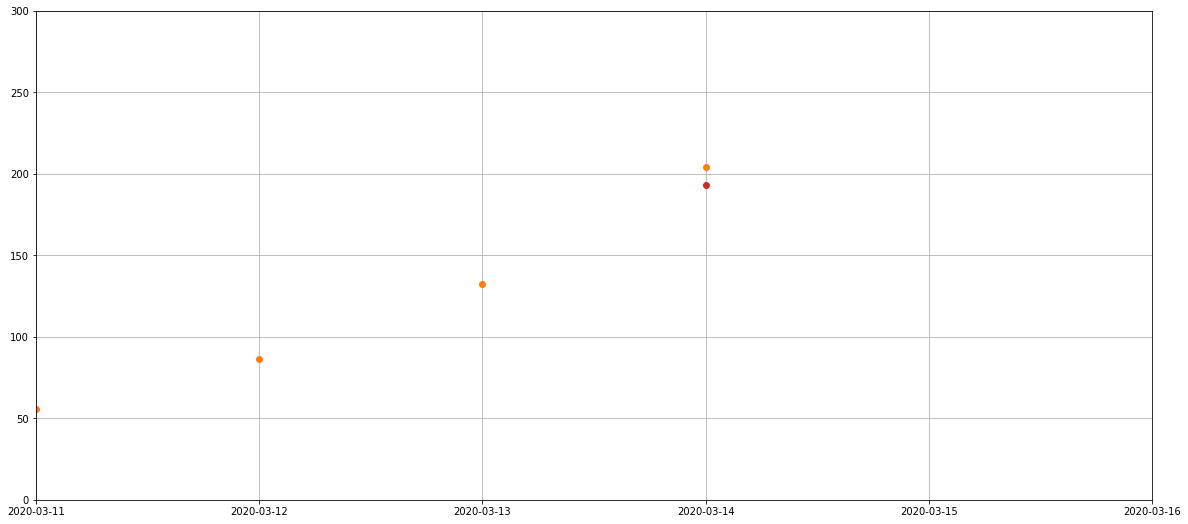

In [38]:
#print(spain)
print(prediction)

plt.plot(prediction['DateTime'], prediction['Confirmed_pred'], 'o')
plt.plot(prediction['DateTime'], prediction['Deaths_pred'], 'o')
plt.plot(prediction['DateTime'].iloc[26], 6321, 'o')
plt.plot(prediction['DateTime'].iloc[26], 193, 'o')

plt.xlim(prediction['DateTime'].iloc[23],prediction['DateTime'].iloc[28])
plt.ylim(0, 300)
plt.grid()

## Other countries in Asia

South Korea has a remarkable recovery rate, with many cases and a reduced number of deaths. Japan growth is moderate, much smaller than in European countries. Iran is showing hints of flattening, although it is curious that the number of recoveries has significantly slowed down while the number of deaths still follow a very exponential trend.

In [48]:
europe_list = [
    ['Korea, South', ''],
    ['Japan', ''],
    ['Iran', '']
]
for country, province in europe_list:
    plot_country(data, country=country, province=province, start_date='2020-02-17', show_numbers=False)

IndexError: invalid index to scalar variable.

# United States

The number of days with cases is still very low, and the fits are not very informative.

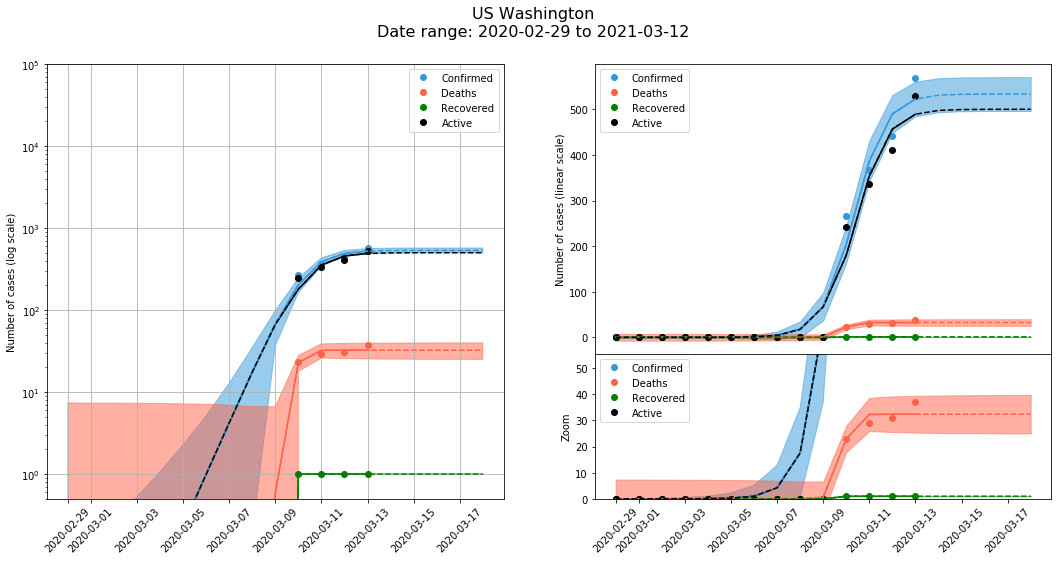

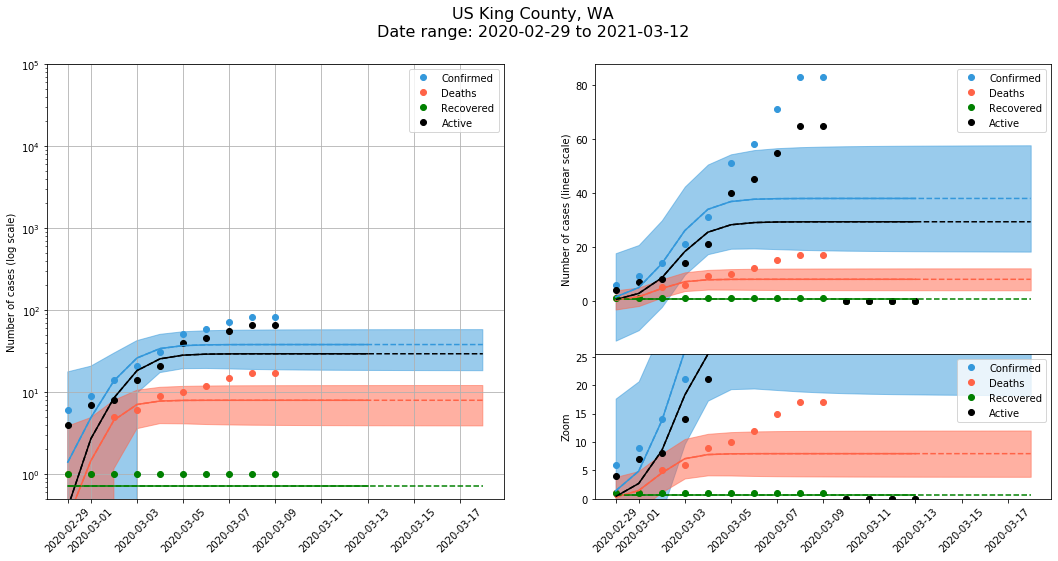

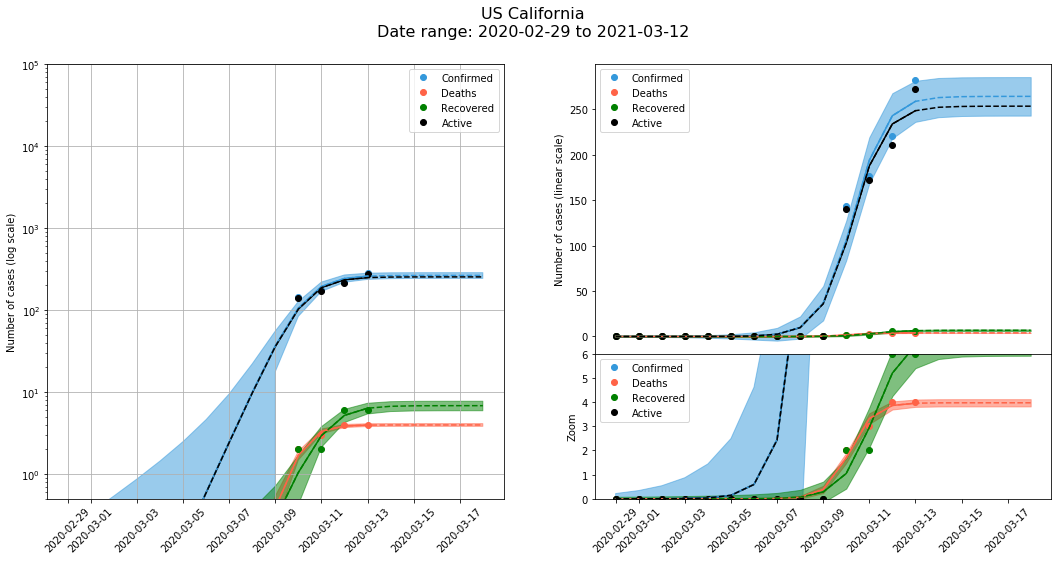

In [55]:
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:50].index
for i in idx:
    country, province = i
    if country == 'US':
        plot_country(data, country=country, province=province, start_date='2020-02-29', show_numbers=False)

# Comparison of two countries, with a manual time delay to align them

In [17]:
def compare_countries(data, country1='Spain', province1='', start_date1='2020-02-15', end_date1='2020-03-12',
                       country2='Spain', province2='', start_date2='2020-01-15', end_date2='2020-03-12',
                       delay=0, show_numbers=False):
    data_country1, prediction1 = fit_data(select_country(data, country=country1, province=province1, start_date=start_date1, end_date=end_date1, show_numbers=False))
    data_country2, prediction2 = fit_data(select_country(data, country=country2, province=province2, start_date=start_date2, end_date=end_date2, show_numbers=False))
    
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 1))
    ax3 = plt.subplot2grid(gridsize, (1, 1))
    plt.subplots_adjust(hspace=0)
    ax1.plot(data_country1['DateTime'], data_country1['Confirmed'], 'o', color='#3498db', label=country1+' Confirmed')
    ax1.plot(data_country1['DateTime'], data_country1['Confirmed_fit'], '-', color='#3498db')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed'], 's', color='k', label=country2+' Confirmed')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed_fit'], '-', color='k')
    ax1.plot(data_country1['DateTime'], data_country1['Deaths'], 'o', color='tomato', label=country1+' Deaths')
    ax1.plot(data_country1['DateTime'], data_country1['Deaths_fit'], '-', color='tomato')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths'], 's', color='g', label=country2+' Deaths')
    ax1.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths_fit'], '-', color='g')
    ax1.set_yscale('log')
    
    ax2.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed'], 's', color='k', label=country2)
    ax2.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Confirmed_fit'], '-', color='k') 
    ax2.plot(data_country1['DateTime'], data_country1['Confirmed'], 'o', color='#3498db', label=country1)
    ax2.plot(data_country1['DateTime'], data_country1['Confirmed_fit'], '-', color='#3498db')
    
    ax3.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths'], 's', color='g', label=country2)
    ax3.plot(data_country2['DateTime']+datetime.timedelta(days=delay), data_country2['Deaths_fit'], '-', color='g')
    ax3.plot(data_country1['DateTime'], data_country1['Deaths'], 'o', color='tomato', label=country1)
    ax3.plot(data_country1['DateTime'], data_country1['Deaths_fit'], '-', color='tomato')
    
    ax1.legend()
    ax1.set_ylim(0.5,1e4)
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)

    fig.suptitle(f'{country1} vs {country2}\nTime delay added: {delay} days', fontsize=16)
    fig.savefig(f'./plots/{country1}{province1}_{country2}{province2}.png', bbox_inches='tight', dpi=150)

    

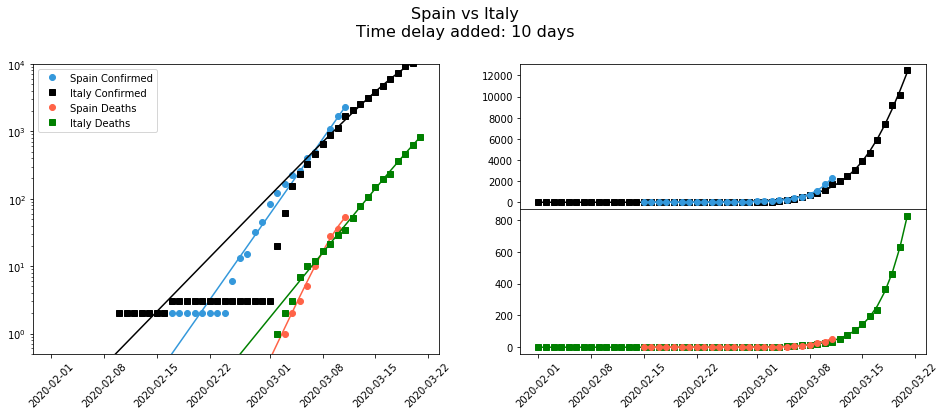

In [18]:
compare_countries(data, country2='Italy', delay=10, show_numbers=False)

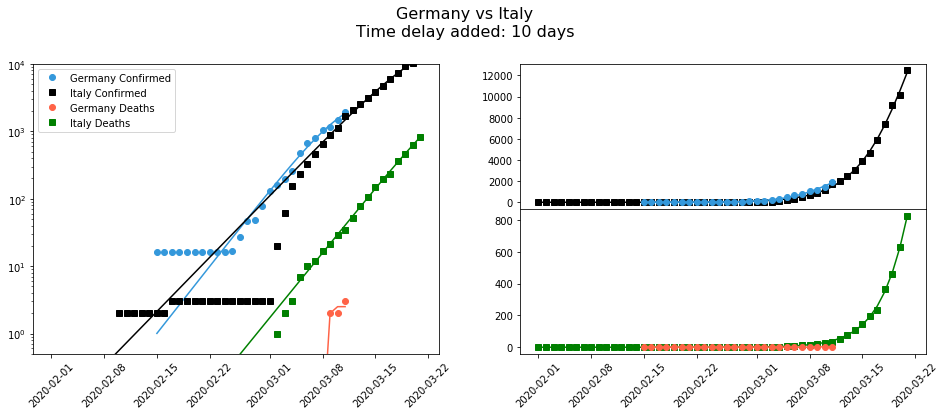

In [19]:
compare_countries(data, country1='Germany', country2='Italy', delay=10)

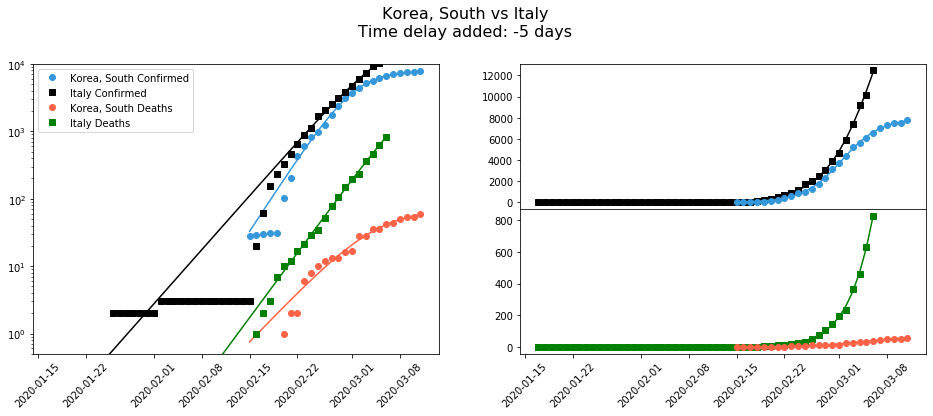

In [20]:
compare_countries(data, country1='Korea, South', country2='Italy', delay=-5)

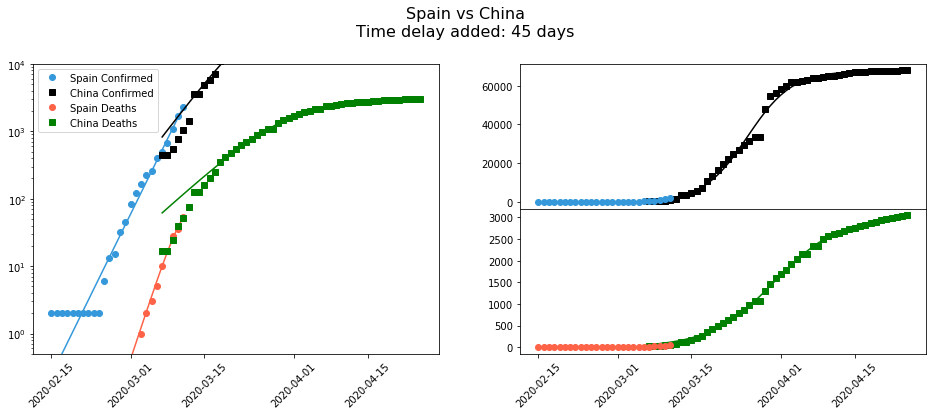

In [28]:
compare_countries(data, country1='Spain', country2='China', province2='Hubei', delay=45)